In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.utils import plot_model

In [2]:
COLUMNS = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
    "occupation", "relationship", "race", "gender", "capital_gain", "capital_loss", 
    "hours_per_week", "native_country", "income_bracket"
]

CATEGORICAL_COLUMNS = [
    "workclass", "education", "marital_status", "occupation", "relationship", 
    "race", "gender", "native_country"
]

CONTINUOUS_COLUMNS = [
    "age", "education_num", "capital_gain", "capital_loss", "hours_per_week"
]

# 데이터 load

In [3]:
train_data = pd.read_csv('./data/adult.data', names=COLUMNS)

In [4]:
print(train_data.shape)
train_data.head()

(32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
train_data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
gender            0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income_bracket    0
dtype: int64

In [6]:
test_data = pd.read_csv('./data/adult.test', skiprows=1, names=COLUMNS)

In [7]:
print(test_data.shape)
test_data.head()

(16281, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [8]:
test_data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
gender            0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income_bracket    0
dtype: int64

# 데이터 concat

In [9]:
data = pd.concat([train_data, test_data])

In [10]:
print(data.shape)
data.head()

(48842, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 라벨 값 생성

In [11]:
data['label'] = data['income_bracket'].apply(lambda x : ">50K" in x).astype(int)

In [12]:
data.iloc[10:15]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,label
10,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K,1
11,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K,1
12,23,Private,122272,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,<=50K,0
13,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,<=50K,0
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K,1


In [13]:
data.drop('income_bracket', axis = 1, inplace=True)

In [14]:
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [15]:
y = data['label'].values
data.drop('label', axis = 1, inplace=True)

In [16]:
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


## 카테고리 값들을 숫자로 변경

In [17]:
for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    data[c] = le.fit_transform(data[c])

In [18]:
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5


# 다시 trian, test로 구분 

In [19]:
train_size = len(train_data)

In [20]:
X_train = data.iloc[:train_size]
y_train = y[:train_size]
X_test = data.iloc[train_size:]
y_test = y[train_size:]

In [21]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

32561 32561 16281 16281


## 카테고리 값들과 연속값들을 뽑아냄

In [22]:
X_train_category = np.array(X_train[CATEGORICAL_COLUMNS])
X_test_category = np.array(X_test[CATEGORICAL_COLUMNS])
X_train_countinue = np.array(X_train[CONTINUOUS_COLUMNS], dtype='float64')
X_test_countinue = np.array(X_test[CONTINUOUS_COLUMNS], dtype='float64')

In [23]:
print( X_train_category[:1] )
print(X_test_category[:1])
print(X_train_countinue[:1])
print(X_test_countinue[:1])

[[ 7  9  4  1  1  4  1 39]]
[[ 4  1  4  7  3  2  1 39]]
[[  39.   13. 2174.    0.   40.]]
[[25.  7.  0.  0. 40.]]


## 정규화

In [24]:
scaler = StandardScaler()
X_train_countinue = scaler.fit_transform(X_train_countinue)
X_test_countinue = scaler.transform(X_test_countinue)

In [25]:
print(X_train_countinue[:1])
print(X_test_countinue[:1])

[[ 0.03067056  1.13473876  0.1484529  -0.21665953 -0.03542945]]
[[-0.99570562 -1.19745882 -0.14592048 -0.21665953 -0.03542945]]


## Polynomial 하게 바꿔줌 (비선형적인 설정으로 선형 회귀를 확장하는 방법. 즉 다항식 함수로 바꿔줌)

카테고리 값을 Polynomial로 바꿔준다.

In [26]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_category_poly = poly.fit_transform(X_train_category)
X_test_category_poly = poly.transform(X_test_category)

In [27]:
print( X_train_category_poly[:1] )
print(X_test_category_poly[:1])

[[  1.   7.   9.   4.   1.   1.   4.   1.  39.  63.  28.   7.   7.  28.
    7. 273.  36.   9.   9.  36.   9. 351.   4.   4.  16.   4. 156.   1.
    4.   1.  39.   4.   1.  39.   4. 156.  39.]]
[[  1.   4.   1.   4.   7.   3.   2.   1.  39.   4.  16.  28.  12.   8.
    4. 156.   4.   7.   3.   2.   1.  39.  28.  12.   8.   4. 156.  21.
   14.   7. 273.   6.   3. 117.   2.  78.  39.]]


In [28]:
n = np.array([[1,2,3]])
poly2 = PolynomialFeatures(degree=2, interaction_only=True)
print(poly.fit_transform(n))

[[1. 1. 2. 3. 2. 3. 6.]]


## 모델 설계

In [29]:
def get_deep_model():

    category_inputs = []
    category_embeds = []
    # 카테고리컬 데이터 임베딩
    for i in range(len(CATEGORICAL_COLUMNS)):
        input_i = Input(shape=(1,), dtype='int32')
        dim = len(np.unique(data[CATEGORICAL_COLUMNS[i]]))
        embed_dim = int(np.ceil(dim ** 0.5)) # embedding 차원을 0.5배 정도로 해서 한다.
        embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
        flatten_i = Flatten()(embed_i)
        category_inputs.append(input_i)
        category_embeds.append(flatten_i)
    # continuous 데이터 input
    continue_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
    continue_dense = Dense(256, use_bias=False)(continue_input)
    # category와 continue를 합침
    concat_embeds = concatenate([continue_dense] + category_embeds)
    concat_embeds = Activation('relu')(concat_embeds)
    bn_concat = BatchNormalization()(concat_embeds)

    fc1 = Dense(512, use_bias=False)(bn_concat)
    relu1 = ReLU()(fc1)
    bn1 = BatchNormalization()(relu1)
    fc2 = Dense(256, use_bias=False)(bn1)
    relu2 = ReLU()(fc2)
    bn2 = BatchNormalization()(relu2)
    fc3 = Dense(128)(bn2)
    relu3 = ReLU()(fc3)
    
    return category_inputs, continue_input, relu3

In [30]:
def get_wide_model():
    dim = X_train_category_poly.shape[1]
    return Input(shape=(dim,))

In [31]:
category_inputs, continue_input, deep_model = get_deep_model()
wide_model = get_wide_model()

## wide 모델과 deep model을 합쳐준다. 

In [32]:
out_layer = concatenate([deep_model, wide_model])
inputs = [continue_input] + category_inputs + [wide_model]
output = Dense(1, activation='sigmoid')(out_layer)
model = Model(inputs=inputs, outputs=output)

In [33]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

In [34]:
checkpoint = ModelCheckpoint(filepath='./data/wide-deep.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

## 입력 데이터

- conti 데이터 -> category 데이터 -> poly data 순으로 입력으로 넣어준다.


In [35]:
input_data = [X_train_countinue] + [X_train_category[:, i] for i in range(X_train_category.shape[1])] + [X_train_category_poly]

In [36]:
epochs = 30
optimizer ='adam'
batch_size = 128

In [37]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(input_data, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=[checkpoint, early_stopping])

Epoch 1/30
212/217 [============================>.] - ETA: 0s - loss: 3.8606 - accuracy: 0.7990
Epoch 00001: val_loss improved from inf to 2.42448, saving model to ./data/wide-deep.h5
217/217 [==============================] - 1s 4ms/step - loss: 3.8025 - accuracy: 0.7989 - val_loss: 2.4245 - val_accuracy: 0.6692
Epoch 2/30
211/217 [============================>.] - ETA: 0s - loss: 0.6523 - accuracy: 0.8123
Epoch 00002: val_loss improved from 2.42448 to 0.88378, saving model to ./data/wide-deep.h5
217/217 [==============================] - 1s 4ms/step - loss: 0.6471 - accuracy: 0.8129 - val_loss: 0.8838 - val_accuracy: 0.7204
Epoch 3/30
211/217 [============================>.] - ETA: 0s - loss: 0.4355 - accuracy: 0.8259
Epoch 00003: val_loss improved from 0.88378 to 0.40923, saving model to ./data/wide-deep.h5
217/217 [==============================] - 1s 4ms/step - loss: 0.4342 - accuracy: 0.8263 - val_loss: 0.4092 - val_accuracy: 0.8174
Epoch 4/30
210/217 [===========================

# Eval

In [38]:
eval_input_data = [X_test_countinue] + [X_test_category[:, i] for i in range(X_test_category.shape[1])] + [X_test_category_poly]

In [39]:
loss, acc = model.evaluate(eval_input_data, y_test)

509/509 [==============================] - 0s 787us/step - loss: 0.3438 - accuracy: 0.8434


In [40]:
print(f'test_loss: {loss} - test_acc: {acc}')

test_loss: 0.3437998592853546 - test_acc: 0.8433757424354553


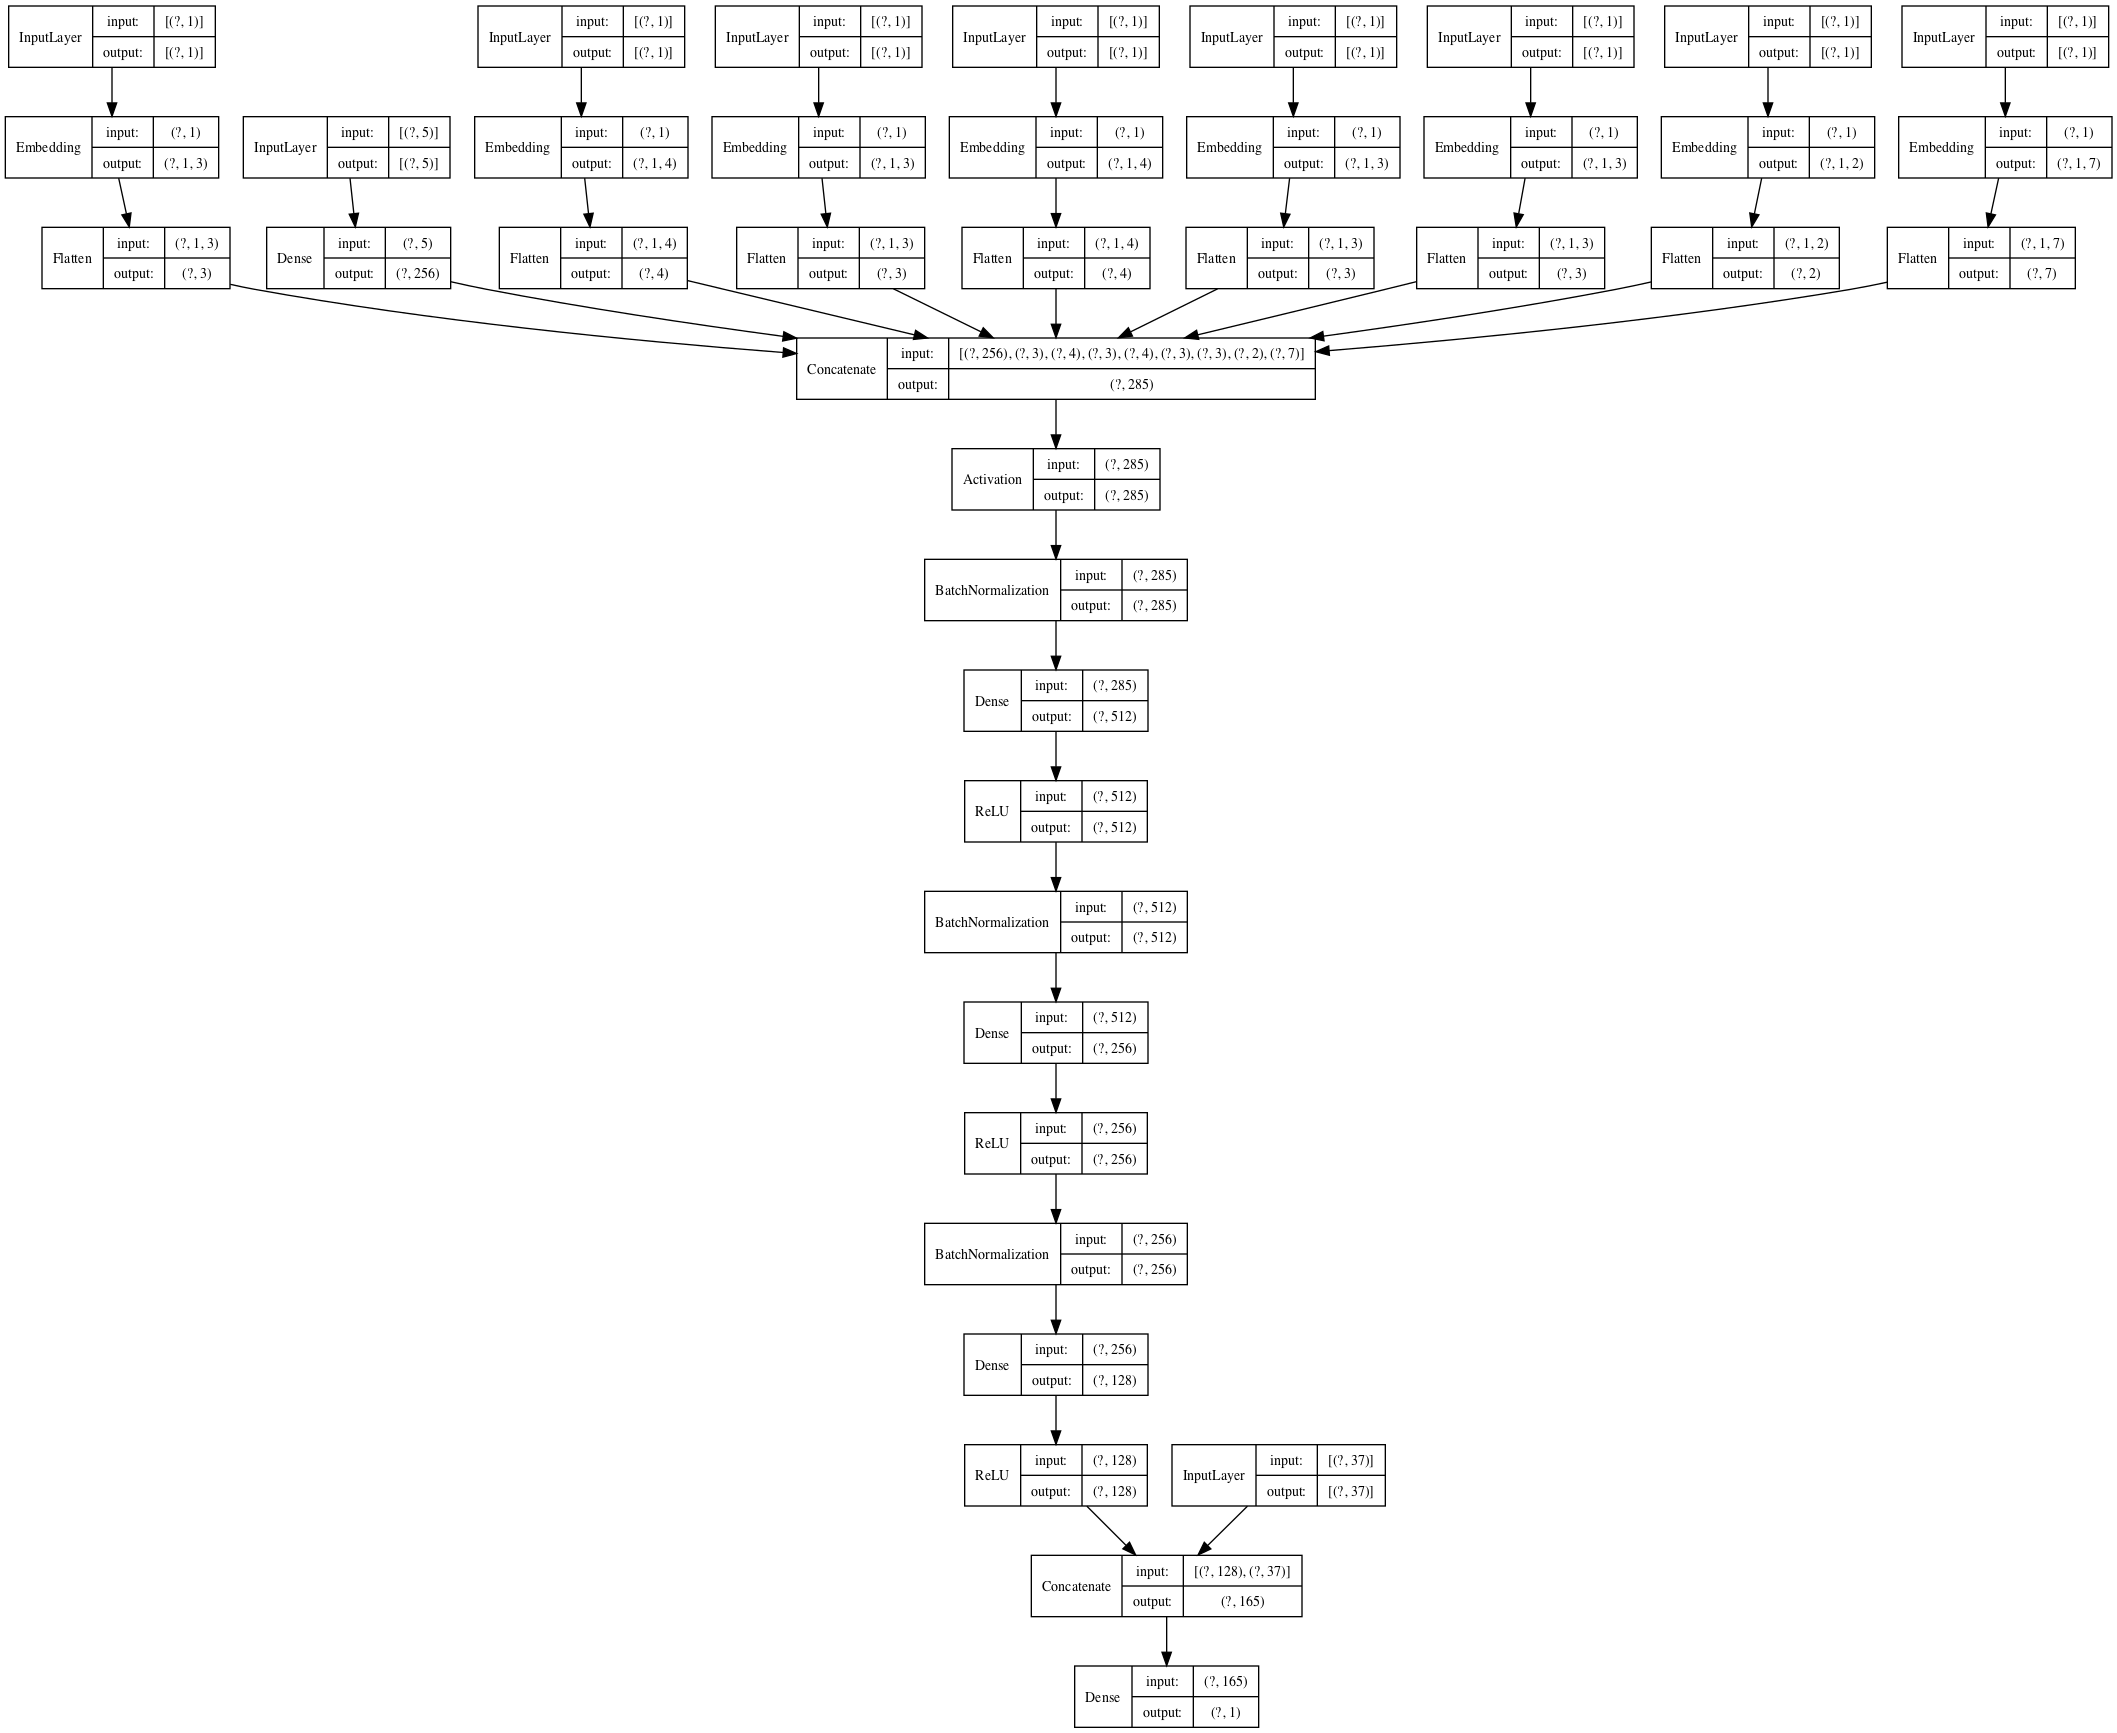

In [41]:
plot_model(model, to_file='./data/model.png', show_shapes=True, show_layer_names=False)